# CycleGAN Monet2Photo

This notebook is for implementing `CycleGAN` from the paper [Unpaired Image-to-Image Translation using Cycle-Consistent Adversarial Networks](https://arxiv.org/abs/1703.10593) with [Tensorflow](https://www.tensorflow.org). <br>
[Monet2Photo dataset](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/), which is 256x256 size, will be used. 

Reference: [hwalsuklee's Github](https://github.com/hwalsuklee/tensorflow-generative-model-collections)

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

## Import Libraries

In [24]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import glob
import cv2 
import datetime
import os

## Parameters


In [44]:
algorithm = 'CycleGAN_Monet2Photo'

img_size   = 256

batch_size = 1
num_epoch  = 60

beta1 = 0.5

gpu_fraction = 0.7

date_time = datetime.datetime.now().strftime("%Y%m%d-%H-%M-%S")

load_model = False
train_model = True

save_path = "./saved_models/" + date_time + "_" + algorithm
load_path = "./saved_models/20190809-11-04-47_CycleGAN_Monet2Photo/model/model" 

## Import Monet2Photo Dataset

Get names of the files in the Horse2Zebra dataset folder.

In [4]:
x_list_train = glob.glob('photo2painting//train_monet/*.jpg')
x_list_test  = glob.glob('photo2painting/test_monet/*.jpg')

y_list_train = glob.glob('photo2painting/train_photo/*.jpg')
y_list_test = glob.glob('photo2painting/test_photo/*.jpg')

print("X Train dataset Length: {}".format(len(x_list_train)))
print("X Test dataset Length: {}".format(len(x_list_test)))
print("Y Train dataset Length: {}".format(len(y_list_train)))
print("Y Test dataset Length: {}".format(len(y_list_test)))

X Train dataset Length: 1072
X Test dataset Length: 121
Y Train dataset Length: 6287
Y Test dataset Length: 751


## Generator

In [5]:
def ResNet(x, is_training, network_name):
        
    h = tf.layers.conv2d(x, filters=512, kernel_size=3, strides=1, padding='SAME', name=network_name+'_1')
    h = tf.contrib.layers.instance_norm(h)
    h = tf.nn.relu(h)
    h = tf.layers.conv2d(h, filters=512, kernel_size=3, strides=1, padding='SAME', name=network_name+'_2')
    h = tf.contrib.layers.instance_norm(h)
    h = x + h 
    h = tf.nn.relu(h)
    
    return h

def Generator(x, network_name, is_training, reuse=False):
    with tf.variable_scope(network_name, reuse=reuse):
        
        # First Conv (c7s1-32)
        e1 = tf.layers.conv2d(x, filters=64, kernel_size=7, strides=1, padding='SAME')
        e1 = tf.contrib.layers.instance_norm(e1)
        e1 = tf.nn.leaky_relu(e1)
        
        # Second Conv (d64)
        e2 = tf.layers.conv2d(e1, filters=128, kernel_size=3, strides=2, padding='SAME')
        e2 = tf.contrib.layers.instance_norm(e2)
        e2 = tf.nn.relu(e2)

        # Third Conv (d128)
        e3 = tf.layers.conv2d(e2, filters=256, kernel_size=3, strides=2, padding='SAME')
        e3 = tf.contrib.layers.instance_norm(e3)
        e3 = tf.nn.relu(e3)

        
        # Third Conv (d128)
        e4 = tf.layers.conv2d(e3, filters=256, kernel_size=3, strides=2, padding='SAME')
        e4 = tf.contrib.layers.instance_norm(e4)
        e4 = tf.nn.relu(e4)

        
        # Third Conv (d128)
        e5 = tf.layers.conv2d(e4, filters=256, kernel_size=3, strides=2, padding='SAME')
        e5 = tf.contrib.layers.instance_norm(e5)
        e5 = tf.nn.relu(e5)

        
        # Third Conv (d128)
        e6 = tf.layers.conv2d(e5, filters=512, kernel_size=3, strides=2, padding='SAME')
        e6 = tf.contrib.layers.instance_norm(e6)
        e6 = tf.nn.relu(e6)

        
        # Third Conv (d128)
        e7 = tf.layers.conv2d(e6, filters=512, kernel_size=3, strides=2, padding='SAME')
        e7 = tf.contrib.layers.instance_norm(e7)
        e7 = tf.nn.relu(e7)

        # Third Conv (d128)
        e8 = tf.layers.conv2d(e7, filters=512, kernel_size=3, strides=2, padding='SAME')
        e8 = tf.contrib.layers.instance_norm(e8)
        e8 = tf.nn.relu(e8)
        
        # ResNet Blocks (R128)
        r1 = ResNet(e8, is_training, 'resnet1')
        r2 = ResNet(r1, is_training, 'resnet2')
        r3 = ResNet(r2, is_training, 'resnet3')
        r4 = ResNet(r3, is_training, 'resnet4')
        r5 = ResNet(r4, is_training, 'resnet5')
        r6 = ResNet(r5, is_training, 'resnet6')
        r7 = ResNet(r6, is_training, 'resnet7')
        r8 = ResNet(r7, is_training, 'resnet8')
        r9 = ResNet(r8, is_training, 'resnet9')

        # FIrst Deconv Layer (u64)
        d1 = tf.layers.conv2d_transpose(r9,filters=512, kernel_size=3, strides=2, padding='SAME')
        d1 = tf.contrib.layers.instance_norm(d1)
        d1 = tf.nn.relu(d1)
        d1 = tf.concat([d1, e7], 3)

        d2 = tf.layers.conv2d_transpose(d1,filters=512, kernel_size=3, strides=2, padding='SAME')
        d2 = tf.contrib.layers.instance_norm(d2)
        d2 = tf.nn.relu(d2)
        d2 = tf.concat([d2, e6], 3)
        
        d3 = tf.layers.conv2d_transpose(d2,filters=512, kernel_size=3, strides=2, padding='SAME')
        d3 = tf.contrib.layers.instance_norm(d3)
        d3 = tf.nn.relu(d3)
        d3 = tf.concat([d3, e5], 3)
        
        d4 = tf.layers.conv2d_transpose(d3,filters=256, kernel_size=3, strides=2, padding='SAME')
        d4 = tf.contrib.layers.instance_norm(d4)
        d4 = tf.nn.relu(d4)
        d4 = tf.concat([d4, e4], 3)

        d5 = tf.layers.conv2d_transpose(d4,filters=256, kernel_size=3, strides=2, padding='SAME')
        d5 = tf.contrib.layers.instance_norm(d5)
        d5 = tf.nn.relu(d5)
        d5 = tf.concat([d5, e3], 3)

        d6 = tf.layers.conv2d_transpose(d5,filters=128, kernel_size=3, strides=2, padding='SAME')
        d6 = tf.contrib.layers.instance_norm(d6)
        d6 = tf.nn.relu(d6)
        d6 = tf.concat([d6, e2], 3)

        d7 = tf.layers.conv2d_transpose(d6,filters=64, kernel_size=3, strides=2, padding='SAME')
        d7 = tf.contrib.layers.instance_norm(d7)
        d7 = tf.nn.relu(d7)
        d7 = tf.concat([d7, e1], 3)

        # Last Conv (c7s1-3)       
        output = tf.tanh(tf.layers.conv2d(d7, filters=3, kernel_size=3, strides=1, padding='SAME')) 
        
        return output

## Discriminator

In [6]:
def Discriminator(x, network_name, is_training, reuse=False):
    with tf.variable_scope(network_name, reuse=reuse):

        # First conv layer (C64)
        h1 = tf.layers.conv2d(x, filters=64, kernel_size=4, strides=2, padding='SAME')
        h1 = tf.nn.leaky_relu(h1)
        
        # Second conv layer
        h2 = tf.layers.conv2d(h1, filters=128, kernel_size=4, strides=2, padding='SAME')
        h2 = tf.contrib.layers.instance_norm(h2)
        h2 = tf.nn.leaky_relu(h2)
        
        # Third conv layer
        h3 = tf.layers.conv2d(h2, filters=256, kernel_size=4, strides=2, padding='SAME')
        h3 = tf.contrib.layers.instance_norm(h3)
        h3 = tf.nn.leaky_relu(h3)

        # Fourth conv layer
        h4 = tf.layers.conv2d(h3, filters=512, kernel_size=4, strides=2, padding='SAME')
        h4 = tf.contrib.layers.instance_norm(h4)
        h4 = tf.nn.leaky_relu(h4)
               
        # Output layer  
        logit  = tf.layers.conv2d(h4, filters=1, kernel_size=4, strides=1, padding='SAME')
        output = tf.sigmoid(logit)  
        
        return logit, output

## GAN

In [7]:
def GAN(x, y, is_training):
    # Generator
    y_gen = Generator(x, 'Gx', is_training)
    x_gen = Generator(y, 'Gy', is_training)

    y_cycle = Generator(x_gen, 'Gx', is_training, reuse = True)
    x_cycle = Generator(y_gen, 'Gy', is_training, reuse = True)
    
    # Discriminator
    D_logit_x_real, D_out_x_real = Discriminator(x, 'Dx', is_training)
    D_logit_y_real, D_out_y_real = Discriminator(y, 'Dy', is_training)
    
    D_logit_x_fake, D_out_x_fake = Discriminator(x_gen, 'Dx', is_training, reuse=True) 
    D_logit_y_fake, D_out_y_fake = Discriminator(y_gen, 'Dy', is_training, reuse=True) 
   
    # get LSGAN loss
    cycle_loss = tf.reduce_mean(tf.abs(x_cycle-x)) + tf.reduce_mean(tf.abs(y_cycle-y))
    identity_loss = tf.reduce_mean(tf.abs(y_gen-x)) + tf.reduce_mean(tf.abs(x_gen-y))
   
    Dx_loss = tf.reduce_mean(tf.square(D_logit_x_real-1)) + tf.reduce_mean(tf.square(D_logit_x_fake))
    Dy_loss = tf.reduce_mean(tf.square(D_logit_y_real-1)) + tf.reduce_mean(tf.square(D_logit_y_fake))
    
    D_loss = Dx_loss + Dy_loss
    
    Gx_loss = tf.reduce_mean(tf.square(D_logit_x_fake-1)) 
    Gy_loss = tf.reduce_mean(tf.square(D_logit_y_fake-1)) 
    
    G_loss = Gx_loss + Gy_loss + 10*cycle_loss + 1.0*identity_loss
   
    
    return x_gen, y_gen, x_cycle, y_cycle, D_loss, G_loss, cycle_loss

## Build Graph

In [8]:
x_ = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 3])
y_ = tf.placeholder(tf.float32, shape=[None, img_size, img_size, 3])

x_normalize = (tf.cast(x_, tf.float32) - (255.0/2)) / (255.0/2)
y_normalize = (tf.cast(y_, tf.float32) - (255.0/2)) / (255.0/2)

is_training = tf.placeholder(tf.bool)

lr = tf.placeholder(tf.float32)

x_gen, y_gen, x_cycle, y_cycle, d_loss, g_loss, c_loss = GAN(x_normalize, y_normalize, is_training) 

# optimization
trainable_variables = tf.trainable_variables()

trainable_variables_d = [var for var in trainable_variables if var.name.startswith('D')]
trainable_variables_g = [var for var in trainable_variables if var.name.startswith('G')]

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_step_d = tf.train.AdamOptimizer(lr, beta1 = beta1).minimize(d_loss, var_list=trainable_variables_d)
    train_step_g = tf.train.AdamOptimizer(lr, beta1 = beta1).minimize(g_loss, var_list=trainable_variables_g)

## Initialization

In [9]:
# Initialize variables
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = gpu_fraction

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

## Load Model

In [21]:
Saver = tf.train.Saver()

if load_model == True:
    Saver.restore(sess, load_path)

## Train

In [ ]:
if train_model:
    # Training
    len_x_train = len(x_list_train)
    len_y_train = len(y_list_train)

    len_data = np.minimum(len_x_train, len_y_train)

    count_step = 0 

    image_buffer_x = []
    image_buffer_y = []

    learning_rate = 0.0002

    for i in range(num_epoch):
        # Shuffle the data 
        np.random.shuffle(x_list_train)
        np.random.shuffle(y_list_train)

        batch_count = 0

        # Making mini-batch
        for j in range(0, len_data, batch_size): 
            if j + batch_size < len_data:
                data_x_batch = np.zeros([batch_size, img_size, img_size, 3])
                data_y_batch = np.zeros([batch_size, img_size, img_size, 3])

                for k in range(batch_size):
                    img_temp_x = cv2.imread(x_list_train[j + k])
                    data_x_batch[k,:,:,:] = img_temp_x

                    img_temp_y = cv2.imread(y_list_train[j + k])
                    data_y_batch[k,:,:,:] = img_temp_y
            else:
                data_x_batch = np.zeros([len_data - j, img_size, img_size, 3])
                data_y_batch = np.zeros([len_data - j, img_size, img_size, 3])

                for k in range(len_data - j):
                    img_temp_x = cv2.imread(x_list_train[j + k])
                    data_x_batch[k,:,:,:] = img_temp_x

                    img_temp_y = cv2.imread(y_list_train[j + k])
                    data_y_batch[k,:,:,:] = img_temp_y

            # Run Optimizer!
            _, D_loss_train = sess.run([train_step_d, d_loss], feed_dict = {x_: data_x_batch, y_: data_y_batch, 
                                                                            is_training: True, lr: learning_rate})                  
            _, G_loss_train = sess.run([train_step_g, g_loss], feed_dict = {x_: data_x_batch, y_: data_y_batch, 
                                                                            is_training: True, lr: learning_rate})            

            batch_count += 1
            print ("Batch: {}".format(j/len_data), end="\r")

        # Print Progess
        print("Epoch: {} / Learning rate: {:.6f} / D Loss: {:.5f} / G Los: {:.5f}".format(
             (i+1), learning_rate, D_loss_train, G_loss_train))

        # Decay learning rate 
        if i >= 30:
            learning_rate -= (0.0002 / 30)

        # Show test images 
        img_test_x = cv2.imread(x_list_test[np.random.randint(len(x_list_test))])
        img_test_y = cv2.imread(y_list_test[np.random.randint(len(y_list_test))])

        x_sample, y_sample, x_cycle_sample, y_cycle_sample = sess.run([x_gen, y_gen, x_cycle, y_cycle], 
                                                                      feed_dict = {x_: [img_test_x], 
                                                                                   y_: [img_test_y], 
                                                                                   is_training: False})
        x_sample = (x_sample + 1.0)/2
        y_sample = (y_sample + 1.0)/2
        x_cycle_sample = (x_cycle_sample + 1.0)/2
        y_cycle_sample = (y_cycle_sample + 1.0)/2

        f, ax = plt.subplots(1,6, figsize=(15,15))

        ax[0].imshow(cv2.cvtColor(img_test_x, cv2.COLOR_BGR2RGB))
        ax[0].axis('off')
        ax[0].set_title('Input X')

        ax[1].imshow(cv2.cvtColor(y_sample[0], cv2.COLOR_BGR2RGB))
        ax[1].axis('off')
        ax[1].set_title('X -> Y')

        ax[2].imshow(cv2.cvtColor(x_cycle_sample[0], cv2.COLOR_BGR2RGB))
        ax[2].axis('off')
        ax[2].set_title('X -> Y -> X')

        ax[3].imshow(cv2.cvtColor(img_test_y, cv2.COLOR_BGR2RGB))
        ax[3].axis('off')
        ax[3].set_title('Input Y')

        ax[4].imshow(cv2.cvtColor(x_sample[0], cv2.COLOR_BGR2RGB))
        ax[4].axis('off')
        ax[4].set_title('Y -> X')

        ax[5].imshow(cv2.cvtColor(y_cycle_sample[0], cv2.COLOR_BGR2RGB))
        ax[5].axis('off')
        ax[5].set_title('Y -> X -> Y')

        plt.show()


## Image Generation (X -> Y -> X)

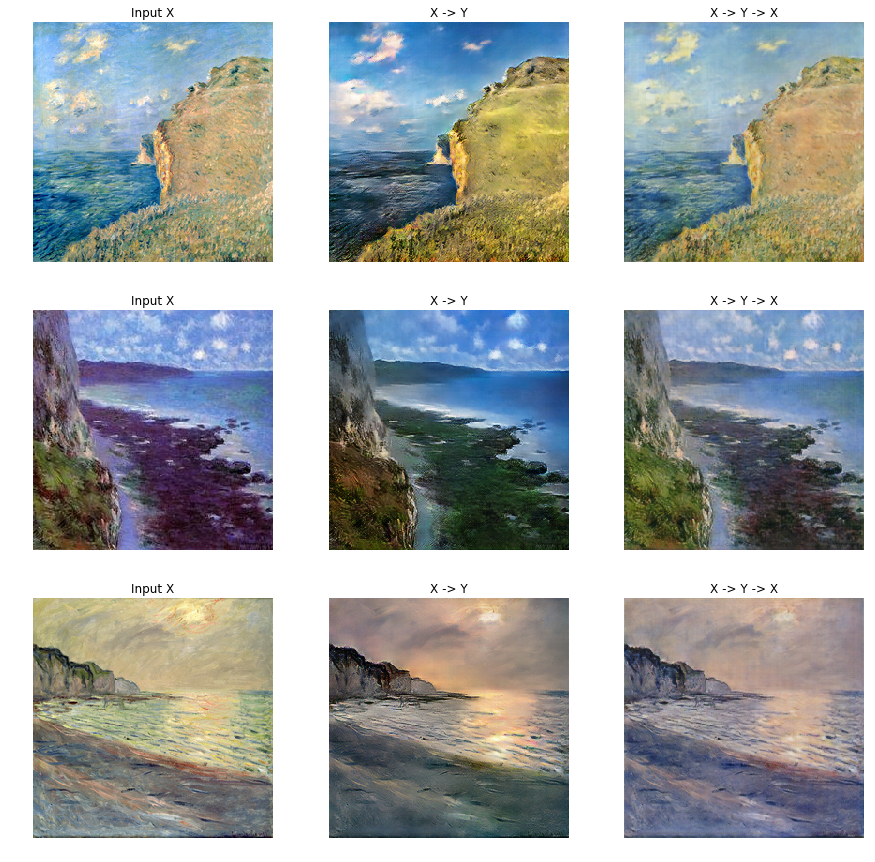

In [38]:
# Show test images 
test_num = 3

f, ax = plt.subplots(test_num,3, figsize=(15,15))

test_list = [13, 14, 45]

for i in range(test_num):
    img_test_x = cv2.imread(x_list_test[test_list[i]])

    y_sample, x_cycle_sample, = sess.run([y_gen, x_cycle], feed_dict = {x_: [img_test_x], is_training: False})

    y_sample = (y_sample + 1.0)/2
    x_cycle_sample = (x_cycle_sample + 1.0)/2

    ax[i,0].imshow(cv2.cvtColor(img_test_x, cv2.COLOR_BGR2RGB))
    ax[i,0].axis('off')
    ax[i,0].set_title('Input X')

    ax[i,1].imshow(cv2.cvtColor(y_sample[0], cv2.COLOR_BGR2RGB))
    ax[i,1].axis('off')
    ax[i,1].set_title('X -> Y')

    ax[i,2].imshow(cv2.cvtColor(x_cycle_sample[0], cv2.COLOR_BGR2RGB))
    ax[i,2].axis('off')
    ax[i,2].set_title('X -> Y -> X')

## Image Generation (Y -> X -> Y)

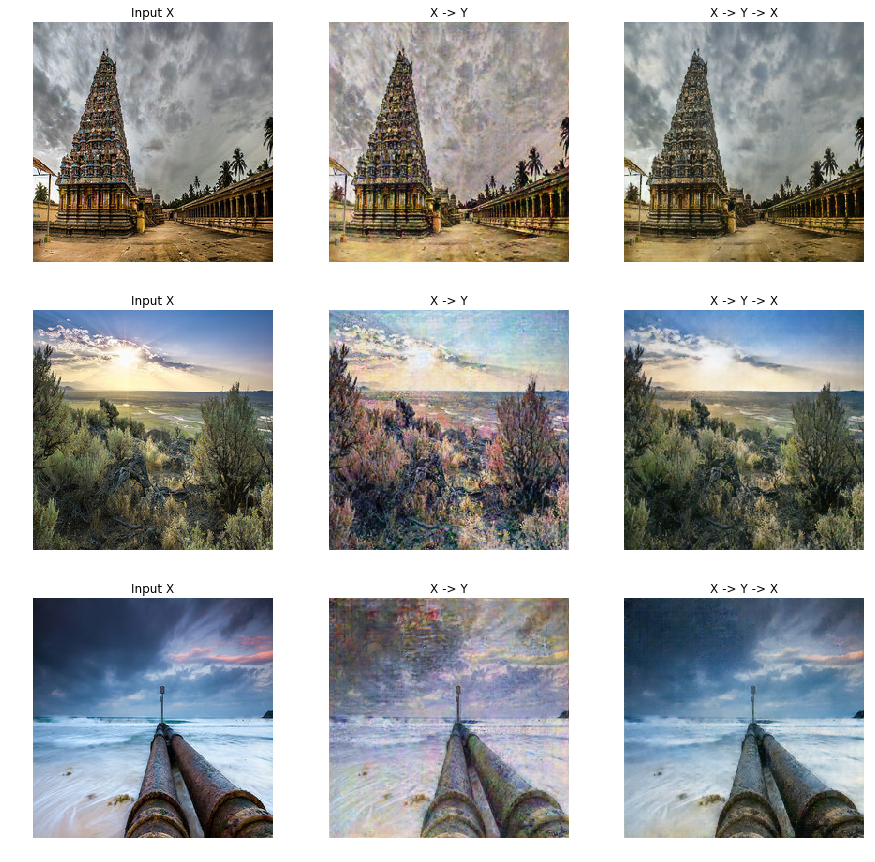

In [58]:
# Show test images 

f, ax = plt.subplots(test_num,3, figsize=(15,15))

test_list = [8, 18, 32]

for i in range(test_num):
    img_test_y = cv2.imread(y_list_test[test_list[i]])

    x_sample, y_cycle_sample, = sess.run([x_gen, y_cycle], feed_dict = {y_: [img_test_y], is_training: False})

    x_sample = (x_sample + 1.0)/2
    y_cycle_sample = (y_cycle_sample + 1.0)/2

    ax[i,0].imshow(cv2.cvtColor(img_test_y, cv2.COLOR_BGR2RGB))
    ax[i,0].axis('off')
    ax[i,0].set_title('Input X')

    ax[i,1].imshow(cv2.cvtColor(x_sample[0], cv2.COLOR_BGR2RGB))
    ax[i,1].axis('off')
    ax[i,1].set_title('X -> Y')

    ax[i,2].imshow(cv2.cvtColor(y_cycle_sample[0], cv2.COLOR_BGR2RGB))
    ax[i,2].axis('off')
    ax[i,2].set_title('X -> Y -> X')

## Save Model

In [46]:
os.mkdir(save_path)

Saver.save(sess, save_path + "/model/model")
print("Model is saved in {}".format(save_path + "/model/model"))

Model is saved in ./saved_models/20190809-11-04-47_CycleGAN_Monet2Photo/model/model
